<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`TransactionStatus`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:


- **TransactionID:** Identificador único alfanumérico para cada transacción.

- **AccountID:** Identificador único de la cuenta asociada a la transacción.

- **TransactionAmount:** Monto de la transacción.

- **TransactionDate:** Fecha y hora de la transacción.

- **TransactionType:** Tipo de transacción (Crédito o Débito).

- **Location:** Ubicación geográfica donde ocurrió la transacción.

- **DeviceID:** Identificador del dispositivo usado para la transacción.

- **IP Address:** Dirección IP asociada a la transacción, que puede cambiar ocasionalmente para algunas cuentas.

- **MerchantID:** Identificador único para los comercios, mostrando tanto comerciantes preferidos como atípicos para cada cuenta.

- **AccountBalance:** Saldo restante en la cuenta después de la transacción.

- **PreviousTransactionDate:** Fecha y hora de la transacción anterior en la cuenta.

- **Channel:** Canal utilizado para realizar la transacción (en línea, sucursal, cajero automático, etc.).

- **CustomerAge:** Edad del titular de la cuenta.

- **CustomerOccupation:** Ocupación del titular de la cuenta (por ejemplo, Doctor, Ingeniero, Estudiante, Jubilado), reflejando patrones de ingresos.

- **TransactionDuration:** Duración de la transacción en segundos.

- **LoginAttempts:** Número de intentos de inicio de sesión antes de realizar la transacción.

- **TransactionStatus:** Variable objetivo que indica si la transacción es "Normal" o "Anómala".


In [14]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Para tratar el problema de desbalance
# -----------------------------------------------------------------------
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

In [15]:
# Importamos el sopooporte de procesamiento de nuestro src
from src import soporte_preprocesamiento as sp

In [16]:
from src import soporte_outliers as so

In [17]:
# Instrucción para visualizar todas las columnas de un dataFrame
pd.set_option('display.max_columns', None)

In [18]:
df = pd.read_csv("datos/financial_data.csv",index_col=0)


In [19]:
df.head()

,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
transaction_id,,,,,,,,,,
1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053
3,1004,2035,1248.86,2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035
4,1095,2037,7619.05,2023-01-01 00:00:03,1,Discover,City-6,Travel,59,Purchase at Merchant-2037
5,1036,2083,1890.10,2023-01-01 00:00:04,1,MasterCard,City-34,Retail,36,Purchase at Merchant-2083


In [20]:
sp.exploracion_datos(df)

El número de filas es 10000 y el número de columnas es 10

----------

En este conjunto de datos tenemos 0 valores duplicados

----------

Los columnas con valores nulos y sus porcentajes son: 


Series([], dtype: float64)


----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
customer_id,10000.0,1051.272300,28.864062,1001.00,1026.000,1052.000,1076.0000,1100.00
merchant_id,10000.0,2050.486600,28.877801,2001.00,2025.000,2050.000,2076.0000,2100.00
amount,10000.0,4958.381617,2899.699675,10.61,2438.175,4943.945,7499.3125,9999.75
is_fraudulent,10000.0,0.506800,0.499979,0.00,0.000,1.000,1.0000,1.00
customer_age,10000.0,44.047500,15.321707,18.00,31.000,44.000,57.0000,70.00



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
transaction_time,10000,10000,2023-01-01 02:46:23,1
card_type,10000,4,Discover,2633
location,10000,50,City-7,223
purchase_category,10000,6,Travel,1694
transaction_description,10000,100,Purchase at Merchant-2016,120



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              10000 non-null  int64  
 1   merchant_id              10000 non-null  int64  
 2   amount                   10000 non-null  float64
 3   transaction_time         10000 non-null  object 
 4   is_fraudulent            10000 non-null  int64  
 5   card_type                10000 non-null  object 
 6   location                 10000 non-null  object 
 7   purchase_category        10000 non-null  object 
 8   customer_age             10000 non-null  int64  
 9   transaction_description  10000 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 859.4+ KB


None

In [21]:
visualizador =sp.Visualizador(df)

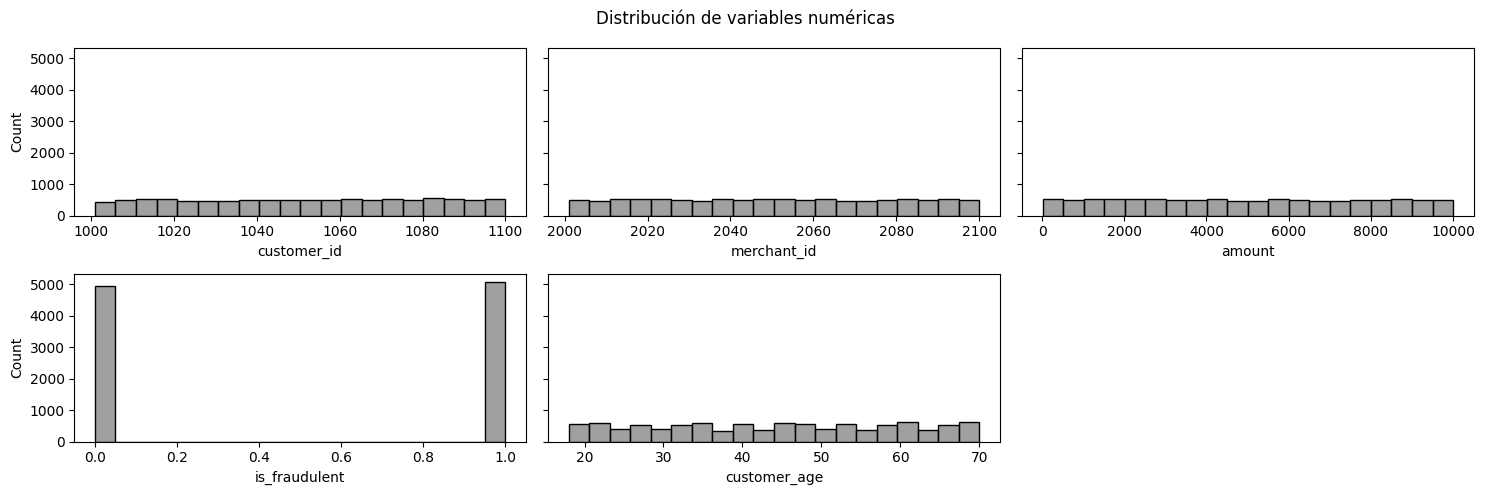

In [22]:
visualizador.plot_numericas()

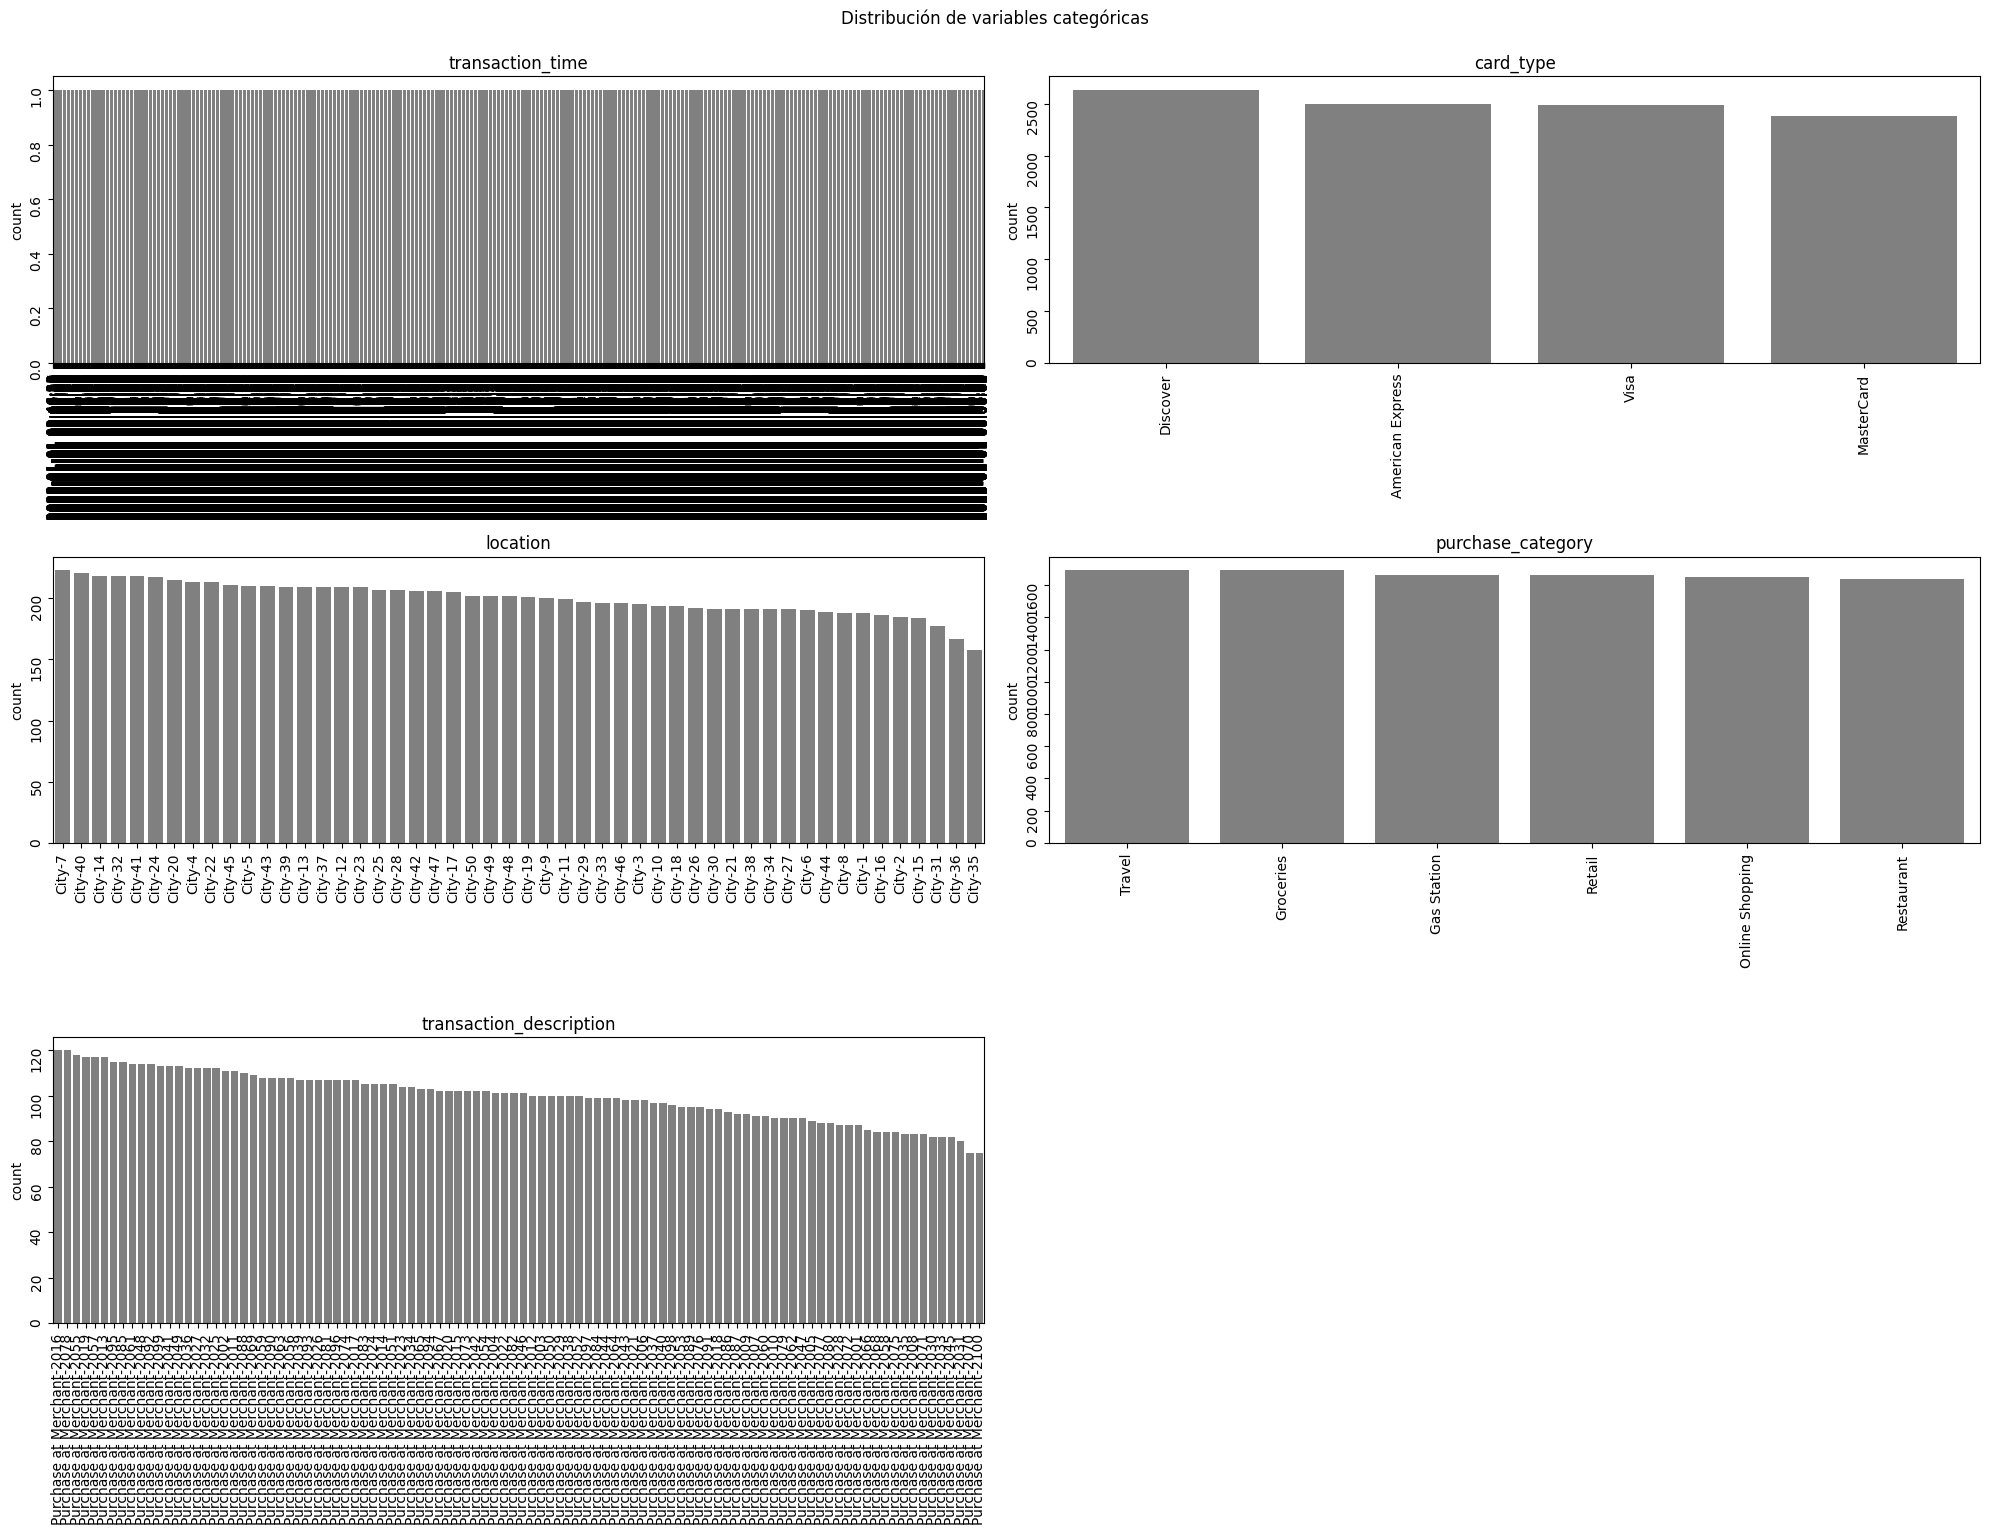

In [23]:
visualizador.plot_categoricas()

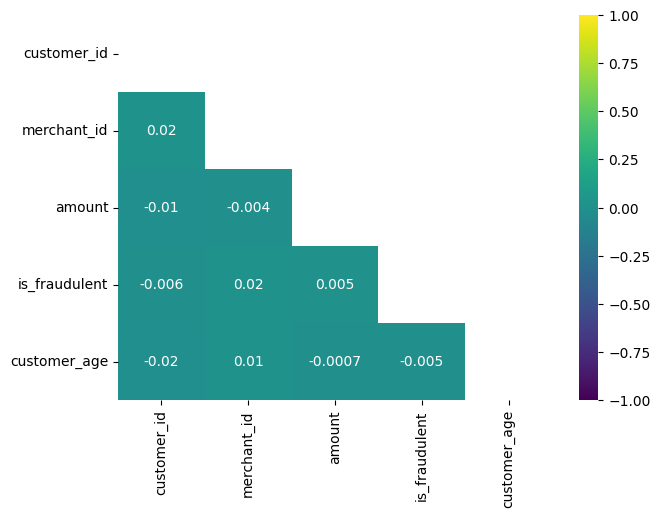

In [24]:
visualizador.correlacion()

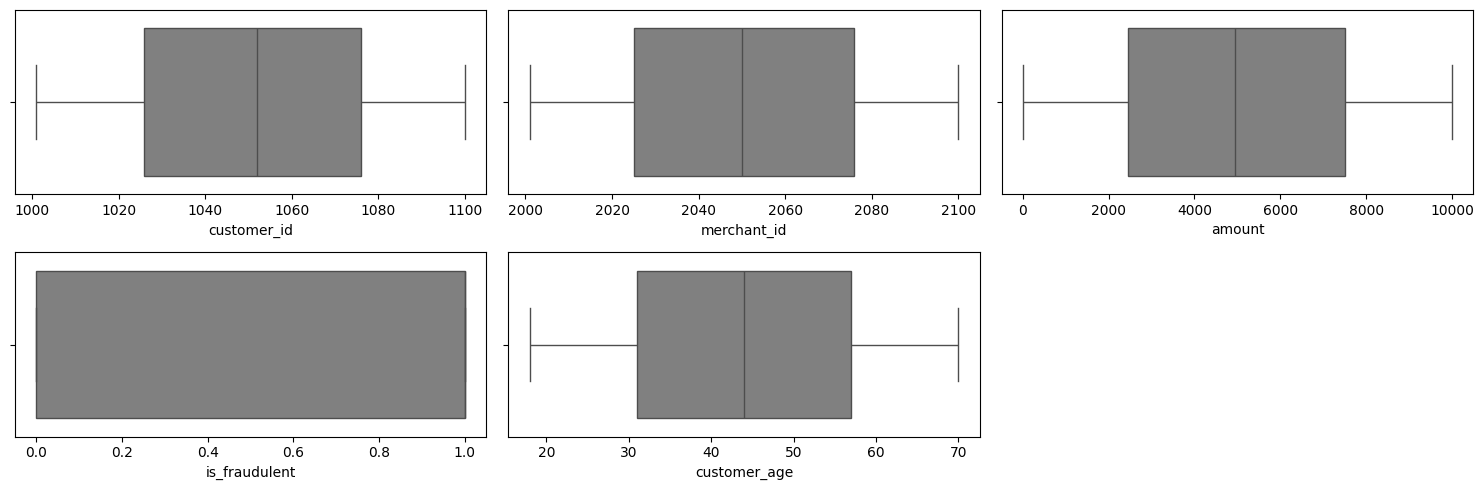

In [25]:
visualizador.deteccion_outliers()